In [1]:
class config:
    EMBS = False
    hyper_params_random_search = False
    save_model = False
    n_components = 50

In [2]:
# !pip install -U catboost
if config.EMBS:
    !pip install transformers
    !pip install -U sentence-transformers

In [3]:
def is_kaggle_gpu_enabled():
    
    """Return whether GPU is enabled in the running Kaggle kernel"""

    from tensorflow.python.client import device_lib

    # when only CPU is enabled the list shows two CPU entries, otherwise there are more, listing GPU as well
    return len(device_lib.list_local_devices()) > 2

In [50]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from catboost import CatBoost
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns

import time
from transformers import pipeline
import tensorflow as tf
# from sentence_transformers import SentenceTransformer

### To do:
* выкачать статьи, определить количество картинок, кода
* Keras BERT
* Keras Dense Regression

In [6]:
train = pd.read_csv('../input/medium-articles-popularity/articles_train.csv', index_col=0)
test = pd.read_csv('../input/medium-articles-popularity/articles_test.csv', index_col=0)
sample_subm = pd.read_csv('../input/medium-articles-popularity/sample_submission.csv')

In [7]:
train

,author,reading_time,link,title,text,claps
id,,,,,,
0,Joseph Rocca,23,https://towardsdatascience.com/understanding-v...,Understanding Variational Autoencoders (VAEs) ...,"Towards Data Science\nSep 24, 2019\nThis post ...",8300.0
1,Guido Vivaldi,6,https://towardsdatascience.com/using-mixed-eff...,Using Mixed-Effects Models For Linear Regressi...,"Towards Data Science\nMay 17, 2019\nMixed-effe...",336.0
2,Jerry Chen,11,https://news.greylock.com/the-new-moats-53f61a...,The New Moats. Why Systems of IntelligenceTM a...,"Greylock Perspectives\nApr 24, 2017\nTo build ...",3500.0
3,Sambasivarao. K,4,https://towardsdatascience.com/region-of-inter...,Region of Interest Pooling. A Technique which ...,"Towards Data Science\nApr 22, 2019\nThe major ...",334.0
4,Ryan Sander,10,https://towardsdatascience.com/modern-gaussian...,Modern Gaussian Process Regression | by Ryan S...,"Towards Data Science\nMar 24, 2021\nEver wonde...",128.0
...,...,...,...,...,...,...
3751,Nerves Foundation,1,https://medium.com/nerves-foundation/nerves-go...,Nerves: “Gold Month of Exchanges” — listed on ...,"Nerves Foundation\nSep 21, 2018\nDear Nervesia...",169.0
3752,Alexandre Xavier,6,https://medium.com/neuronio/an-introduction-to...,An introduction to ConvLSTM. Nowadays it is qu...,"Neuronio\nMar 25, 2019\nNote: a Portuguese ver...",768.0
3753,Luís Gonçalves,4,https://medium.com/luisfredgs/automatic-text-s...,Automatic Text Summarization Made Simple | lui...,"luisfredgs\nApr 19, 2020\nSummarization conden...",144.0


In [8]:
test

,author,reading_time,link,title,text
id,,,,,
3756,Rohit Thakur,8,https://towardsdatascience.com/step-by-step-r-...,Step-by-Step R-CNN Implementation From Scratch...,"Towards Data Science\nOct 18, 2019\nClassifica..."
3757,Giuliano Giacaglia,14,https://towardsdatascience.com/transformers-14...,How Transformers Work. Transformers are a type...,"Towards Data Science\nMar 11, 2019\nIf you lik..."
3758,Darshan Adakane,7,https://towardsdatascience.com/neural-style-tr...,Neural Style Transfer using VGG model | by Dar...,"Towards Data Science\nJan 16, 2020\nIntroducti..."
3759,Sachin Palewar,1,https://medium.com/@palewar/amazons-artificial...,Amazon’s Artificial Artificial Intelligence | ...,"Nov 21, 2005\nToday, we build complex software..."
3760,SDGCounting,2,https://medium.com/sdg-counting/this-week-in-t...,"This week in the #SDGs- February 17, 2017 | by...","SDG Counting\nFeb 17, 2017\n1 . IISD provided ..."
...,...,...,...,...,...
4251,Tiago M. Leite,9,https://medium.com/ensina-ai/redes-neurais-per...,"Redes Neurais, Perceptron Multicamadas e o Alg...","Ensina.AI\nMay 10, 2018\nVocê já se pergunto..."
4252,Tejan Karmali,6,https://towardsdatascience.com/spam-classifier...,Spam Classifier in Python from scratch | by Te...,"Towards Data Science\nAug 2, 2017\nWe all face..."
4253,Insight,5,https://blog.insightdatascience.com/preparing-...,Preparing for Insight | by Insight | Insight,"Insight\nApr 16, 2014\nJohn Joo is an Insight ..."


features

In [10]:
train['link_1'] = train['link'].str.split('/').str[2]
test['link_1'] = test['link'].str.split('/').str[2]

# le = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# train['link_1'] = le.fit_transform(train['link_1'].values[:, None])
# test['link_1'] = le.transform(test['link_1'].values[:, None])

In [ ]:
# Scaling
# train['link_1'] = train['link_1'] / train['link_1'].max()
# test['link_1'] = test['link_1'] / test['link_1'].max()

# train['reading_time'] = train['reading_time'] / train['reading_time'].max()
# test['reading_time'] = test['reading_time'] / test['reading_time'].max()

In [11]:
train['author_1'] = train['author'].str.split(' ').str[0]
test['author_1'] = test['author'].str.split(' ').str[0]

train['author_2'] = train['author'].str.split(' ').str[1]
test['author_2'] = test['author'].str.split(' ').str[1]

In [12]:
train['text_1'] = train['text'].str.split('\n').str[0]
train['text_2'] = train['text'].str.split('\n').str[1].str.split(' ').str[0]
train['text_3'] = train['text'].str.split('\n').str[1].str.split(' ').str[1]
train['text_4'] = train['text'].str.split('\n').str[1].str.split(' ').str[2]
train['text_5'] = train['text'].str.split('\n').str[2].str.split('.').str[0]

train['title_1'] = train['title'].str.split(' ').str[0]
train['title_2'] = train['title'].str.split(' ').str[1]
train['title_3'] = train['title'].str.split(' ').str[2]
train['title_4'] = train['title'].str.split(' ').str[3]

test['text_1'] = test['text'].str.split('\n').str[0]
test['text_2'] = test['text'].str.split('\n').str[1].str.split(' ').str[0]
test['text_3'] = test['text'].str.split('\n').str[1].str.split(' ').str[1]
test['text_4'] = test['text'].str.split('\n').str[1].str.split(' ').str[2]
test['text_5'] = test['text'].str.split('\n').str[2].str.split('.').str[0]

test['title_1'] = test['title'].str.split(' ').str[0]
test['title_2'] = test['title'].str.split(' ').str[1]
test['title_3'] = test['title'].str.split(' ').str[2]
test['title_4'] = test['title'].str.split(' ').str[3]

In [13]:
train['read_time_link_1_mean'] = train.groupby(['link_1'])['reading_time'].transform('mean')
train['read_time_link_1_max'] = train.groupby(['link_1'])['reading_time'].transform('max')

test['read_time_link_1_mean'] = test.groupby(['link_1'])['reading_time'].transform('mean')
test['read_time_link_1_max'] = test.groupby(['link_1'])['reading_time'].transform('max')

train['claps_link_1_mean'] = train.groupby(['link_1'])['claps'].transform('mean')
train['claps_link_1_max'] = train.groupby(['link_1'])['claps'].transform('max')

In [14]:
test = test.join(train.drop_duplicates('link_1').set_index('link_1')['claps_link_1_mean'], on='link_1', how='left')
test = test.join(train.drop_duplicates('link_1').set_index('link_1')['claps_link_1_max'], on='link_1', how='left')
train.shape, test.shape

((3756, 22), (500, 21))

In [19]:
# train.drop(columns=['text', 'title', 'link', 'reading_time', 'author']).head(2)

,claps,link_1,author_1,author_2,text_1,text_2,text_3,text_4,text_5,title_1,title_2,title_3,title_4,read_time_link_1_mean,read_time_link_1_max,claps_link_1_mean,claps_link_1_max
id,,,,,,,,,,,,,,,,,
0,8300.0,towardsdatascience.com,Joseph,Rocca,Towards Data Science,Sep,"24,",2019,This post was co-written with Baptiste Rocca,Understanding,Variational,Autoencoders,(VAEs),9.385315,67,1692.469136,52000.0
1,336.0,towardsdatascience.com,Guido,Vivaldi,Towards Data Science,May,"17,",2019,Mixed-effects regression models are a powerful...,Using,Mixed-Effects,Models,For,9.385315,67,1692.469136,52000.0


#### tfidf, truncated_svd

In [22]:
train.head(2)

,author,reading_time,link,title,text,claps,link_1,author_1,author_2,text_1,...,text_4,text_5,title_1,title_2,title_3,title_4,read_time_link_1_mean,read_time_link_1_max,claps_link_1_mean,claps_link_1_max
id,,,,,,,,,,,,,,,,,,,,,
0,Joseph Rocca,23,https://towardsdatascience.com/understanding-v...,Understanding Variational Autoencoders (VAEs) ...,"Towards Data Science\nSep 24, 2019\nThis post ...",8300.0,towardsdatascience.com,Joseph,Rocca,Towards Data Science,...,2019,This post was co-written with Baptiste Rocca,Understanding,Variational,Autoencoders,(VAEs),9.385315,67,1692.469136,52000.0
1,Guido Vivaldi,6,https://towardsdatascience.com/using-mixed-eff...,Using Mixed-Effects Models For Linear Regressi...,"Towards Data Science\nMay 17, 2019\nMixed-effe...",336.0,towardsdatascience.com,Guido,Vivaldi,Towards Data Science,...,2019,Mixed-effects regression models are a powerful...,Using,Mixed-Effects,Models,For,9.385315,67,1692.469136,52000.0


In [23]:
# fill na
train['author_2'] = train['author_2'].fillna(' ')
test['author_2'] = test['author_2'].fillna(' ')

train['text_2'] = train['text_2'].fillna(' ')
test['text_2'] = test['text_2'].fillna(' ')

train['text_3'] = train['text_3'].fillna(' ')
test['text_3'] = test['text_3'].fillna(' ')

train['text_4'] = train['text_4'].fillna(' ')
test['text_4'] = test['text_4'].fillna(' ')

In [24]:
columns_e  = ['author', 'title', 'text', 'link_1', 'author_1', 'author_2', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5', 'title_1', 'title_2', 'title_3', 'title_4']

In [26]:
vectorizer = TfidfVectorizer()
svd = TruncatedSVD(config.n_components, random_state=42)

for col in columns_e:
    X = vectorizer.fit_transform(train[col])
    X_t = vectorizer.transform(test[col])
    
    X_ = svd.fit_transform(X)
    for idx, el in enumerate(X_.T):
        train[col + '_e'+str(idx)] = el
    
    X_t_ = svd.transform(X_t)
    for idx, el in enumerate(X_t_.T):
        test[col + '_e'+str(idx)] = el

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


### Embs

In [ ]:
if config.EMBS:
    if is_kaggle_gpu_enabled():
        st_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2') # https://www.sbert.net/examples/applications/computing-embeddings/README.html
    else:
        print("GPU isn't enabled")
        config.EMBS = False

In [ ]:
if config.EMBS:
    train_title = st_model.encode(train['title'].values, batch_size=256)
    train_author = st_model.encode(train['author'].values, batch_size=256)
    train_text = st_model.encode(train['text'].values, batch_size=256)

In [ ]:
if config.EMBS:
    test_title = st_model.encode(test['title'].values, batch_size=256)
    test_author = st_model.encode(test['author'].values, batch_size=256)
    test_text = st_model.encode(test['text'].values, batch_size=256)
# pipeline = pipeline('feature-extraction', model='xlnet-base-cased')
# data = pipeline("this is a test")

In [27]:
train.head(2)

,author,reading_time,link,title,text,claps,link_1,author_1,author_2,text_1,...,title_4_e40,title_4_e41,title_4_e42,title_4_e43,title_4_e44,title_4_e45,title_4_e46,title_4_e47,title_4_e48,title_4_e49
id,,,,,,,,,,,,,,,,,,,,,
0,Joseph Rocca,23,https://towardsdatascience.com/understanding-v...,Understanding Variational Autoencoders (VAEs) ...,"Towards Data Science\nSep 24, 2019\nThis post ...",8300.0,towardsdatascience.com,Joseph,Rocca,Towards Data Science,...,5.063354e-04,1.074876e-03,8.924031e-05,-1.912341e-03,1.628662e-04,-2.223587e-03,1.667354e-03,1.248571e-03,1.082986e-03,4.410312e-03
1,Guido Vivaldi,6,https://towardsdatascience.com/using-mixed-eff...,Using Mixed-Effects Models For Linear Regressi...,"Towards Data Science\nMay 17, 2019\nMixed-effe...",336.0,towardsdatascience.com,Guido,Vivaldi,Towards Data Science,...,1.465044e-07,2.553961e-07,5.807326e-08,-3.163092e-07,5.536111e-08,1.055572e-07,1.014790e-07,2.303837e-07,1.235535e-07,1.961608e-07


In [ ]:
train.columns

In [28]:
cat_cols = ['link_1',\
       'author_1', 'author_2', 'text_1', 'text_2', 'text_3', 'text_4',\
        'title_1', 'title_2', 'title_3', 'title_4']

In [29]:
# drop columns:
train = train.drop(columns=['text', 'author', 'link', 'title', 'text_5'])
test = test.drop(columns=['text', 'author', 'link', 'title', 'text_5'])

In [ ]:
# train_pool = Pool(train.drop(columns=['claps']+text_cols), train['claps'], cat_features=cat_cols)
# test_pool = Pool(test.drop(columns=text_cols), cat_features=cat_cols)

In [ ]:
if config.EMBS:
    train_X = np.concatenate((train_title, train_author, train['link_1'].values[:, None], train.reading_time.values[:, None]), axis=1)
    train_y = train['claps']

    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    
    # embs
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_test, y_test)
    test_pool = Pool(np.concatenate((test_title, test_author, test['link_1'].values[:, None], test.reading_time.values[:, None]), axis=1))

In [30]:
if not config.EMBS:
    train_part = train.sample(frac=0.8,random_state=200)
    val_part = train.drop(train_part.index)

    train_part_X = train_part.drop(columns=['claps'])
    train_part_y = train_part['claps']

    val_part_X = val_part.drop(columns=['claps'])
    val_part_y = val_part['claps']
    
    print(train_part.shape, val_part.shape)
    
    #log target
    train_part_y = np.log1p(train_part_y)
    val_part_y = np.log1p(val_part_y)
    
    train_pool = Pool(train_part_X, train_part_y, cat_features=cat_cols)
    val_pool = Pool(val_part_X, val_part_y, cat_features=cat_cols)
    test_pool = Pool(test, cat_features=cat_cols)

(3005, 767) (751, 767)


### LinearReg

In [ ]:
# sc = StandardScaler()

# X = train[['reading_time', 'read_time_link_1_mean', 'read_time_link_1_max', 'claps_link_1_mean', 'claps_link_1_max', 'author_e', 'title_e', 'title_1_e', 'title_2_e', 'title_3_e', 'title_4_e','text_1_e', 'text_2_e', 'text_3_e', 'text_4_e', 'text_5_e']].values
# X = sc.fit_transform(X)
# y = train['claps']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# reg = LinearRegression().fit(X_train, y_train)
# mean_absolute_error(y_test, reg.predict(X_test))

#### Hyper-parameter tuning


https://stackoverflow.com/questions/52989242/bayesian-optimisation-applied-in-catboost

In [ ]:
if config.hyper_params_random_search:
    model = CatBoostRegressor(verbose=False)

In [ ]:
# model.get_all_params()

In [ ]:
grid = {'iterations': [1000],
        'learning_rate': [0.03, 0.06, 0.1],
        'depth': [4, 6, 10, 12, 15],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 12, 15],
#         'colsample_bylevel': [0.01, 0.05, 0.1],
#         'boosting_type': ["Ordered", "Plain"],
#         'grow_policy': ['SymmetricTree', 'Depthwise'],
#         'bagging_temperature': [1, 2, 3],
        'rsm': [0.1, 0.25, 0.5, 0.9]}

if config.hyper_params_random_search:
    randomized_search_result = model.randomized_search(grid, train_pool, cv=3, train_size=0.8, verbose=False)
    best_params = randomized_search_result['params']
    print(best_params)

### Baseline model

In [31]:
if not config.hyper_params_random_search:
#     best_params = {'depth': 12, 'l2_leaf_reg': 15, 'iterations': 6000, 'rsm': 0.1, 'learning_rate': 0.06, 'grow_policy': 'Depthwise', 'boosting_type': 'Plain'}
    best_params = {'depth': 9, 'l2_leaf_reg': 1, 'iterations': 1800, 'rsm': 0.07, 'learning_rate': 0.06, 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain'}
#     best_params = {'depth': 9, 'l2_leaf_reg': 1, 'iterations': 1800, 'rsm': 0.1, 'learning_rate': 0.06, 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain'}

In [32]:
if is_kaggle_gpu_enabled():
    model = CatBoostRegressor(iterations=20000, task_type="GPU", devices='0:1', random_seed=42)
else:
    if not config.hyper_params_random_search:
#     model = CatBoostRegressor(iterations=8000, depth=12, l2_leaf_reg=9)
        model = CatBoostRegressor(**best_params)
    #     model = CatBoostRegressor(iterations=40000, learning_rate=0.01, l2_leaf_reg=3, depth=5) # https://catboost.ai/en/docs/references/training-parameters/common

#### fit

In [33]:
model.fit(train_pool, verbose=100, use_best_model=True, eval_set=val_pool)

0:	learn: 2.4333870	test: 2.3873880	best: 2.3873880 (0)	total: 156ms	remaining: 4m 40s
100:	learn: 0.9576145	test: 1.4413127	best: 1.4413127 (100)	total: 9.44s	remaining: 2m 38s
200:	learn: 0.5524335	test: 1.3645967	best: 1.3645967 (200)	total: 29.9s	remaining: 3m 57s
300:	learn: 0.3199702	test: 1.3436691	best: 1.3436691 (300)	total: 51.8s	remaining: 4m 17s
400:	learn: 0.1929255	test: 1.3375464	best: 1.3375464 (400)	total: 1m 1s	remaining: 3m 35s
500:	learn: 0.1234400	test: 1.3362382	best: 1.3362382 (500)	total: 1m 11s	remaining: 3m 5s
600:	learn: 0.0839645	test: 1.3344376	best: 1.3342878 (590)	total: 1m 21s	remaining: 2m 42s
700:	learn: 0.0592005	test: 1.3342530	best: 1.3339828 (668)	total: 1m 31s	remaining: 2m 23s
800:	learn: 0.0428932	test: 1.3343757	best: 1.3339828 (668)	total: 1m 41s	remaining: 2m 6s
900:	learn: 0.0319661	test: 1.3344050	best: 1.3339828 (668)	total: 1m 50s	remaining: 1m 50s
1000:	learn: 0.0244789	test: 1.3343063	best: 1.3339828 (668)	total: 2m	remaining: 1m 36s
11

In [ ]:
if config.save_model:
    model.save_model('base_model')

#### eval

In [40]:
eval_preds = model.predict(val_pool) # 649

#exp target
eval_preds = np.expm1(eval_preds)
val_part_y_ = np.expm1(val_part_y)

eval_preds = np.where(eval_preds <= 1, 1, eval_preds)
mean_absolute_error(val_part_y_, eval_preds)

662.5961847336101

In [76]:
val_pred_analysis = pd.DataFrame({'true': val_part_y_, 'pred': eval_preds})
val_pred_analysis['diff'] = abs(val_pred_analysis['pred'] - val_pred_analysis['true'])
val_pred_analysis.sort_values(by='diff', ascending=False)

,true,pred,diff
id,,,
3087,61000.0,118.358906,60881.641094
2348,51000.0,235.389113,50764.610887
2696,42000.0,2716.282890,39283.717110
3396,17500.0,150.042331,17349.957669
819,17500.0,150.042331,17349.957669
...,...,...,...
124,8.0,7.585769,0.414231
1162,1.0,1.282007,0.282007
1588,19.0,19.022267,0.022267


In [101]:
train.loc[2696, :].head(20)

reading_time                                 10
claps                                   42000.0
link_1                   towardsdatascience.com
author_1                                     YK
author_2                                   Sugi
text_1                     Towards Data Science
text_2                                      Jun
text_3                                      15,
text_4                                     2018
title_1                                    What
title_2                                 exactly
title_3                                     can
title_4                                     you
read_time_link_1_mean                  9.385315
read_time_link_1_max                         67
claps_link_1_mean                   1692.469136
claps_link_1_max                        52000.0
author_e0                                   0.0
author_e1                                   0.0
author_e2                                   0.0
Name: 2696, dtype: object

#### Predict

In [41]:
preds = model.predict(test_pool)

#exp
preds = np.expm1(preds)

In [ ]:
sample_subm_old = sample_subm.copy()

In [ ]:
sample_subm_old['claps_old'] = sample_subm['claps']

sample_subm['claps'] = sample_subm_old[['claps', 'claps_old']].mean(axis=1)
sample_subm['claps'] = sample_subm['claps'].apply(lambda x : x if x > 1 else 1)
sample_subm.to_csv('base_10_ef_tuned_params_final.csv', index=False)

In [ ]:
sample_subm['claps'] = preds
sample_subm['claps'] = sample_subm['claps'].apply(lambda x : x if x > 1 else 1)
sample_subm.to_csv('base_10_ef_tuned_params.csv', index=False)
sample_subm

In [42]:
fe = model.get_feature_importance()

In [43]:
fe = zip(np.arange(0,1538), fe)

In [44]:
fe = sorted(fe, key=lambda x: x[1])

In [ ]:
list(fe)

In [ ]:
test.iloc[:, 7]

In [52]:
def plot_feature_importance(importance,names, max_feat=10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:max_feat]
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('Feature importance')
    return fi_df

,feature_names,feature_importance
0,reading_time,6.914232
7,text_4,4.372461
467,text_4_e1,2.031878
2,author_1,1.881960
479,text_4_e13,1.676602
318,text_1_e2,1.391506
4,text_1,1.218174
3,author_2,1.198681
66,title_e0,1.038872
508,text_4_e42,0.941200


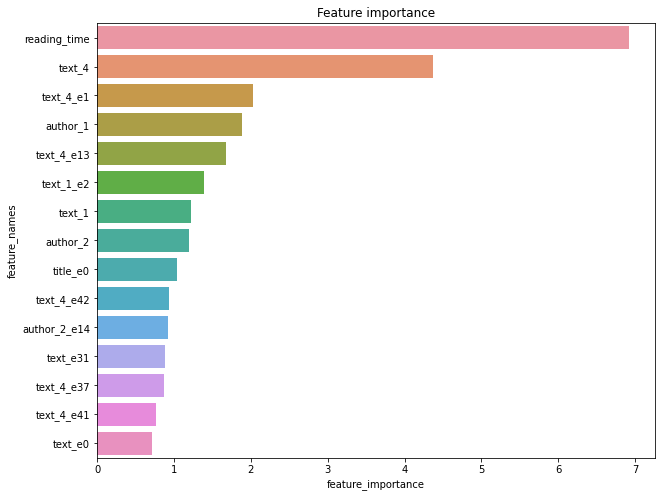

In [54]:
plot_feature_importance(model.get_feature_importance(),train_part_X.columns, max_feat=15)

In [67]:
train_part_X['text_4']

id
2533           2020
2966        writing
1073    fine-tuning
2814           2015
3219           2020
           ...     
3340           2019
2482           2019
80             2017
1793           2020
2549           from
Name: text_4, Length: 3005, dtype: object

### SHAP

In [102]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(train_part_X)

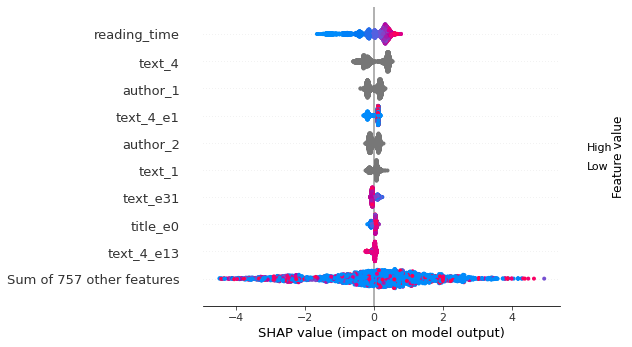

In [103]:
shap.plots.beeswarm(shap_values)

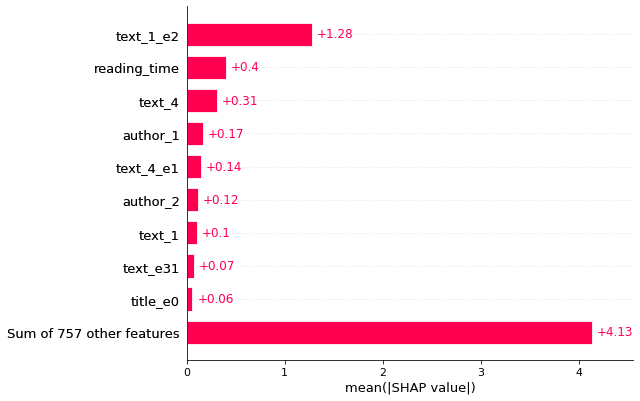

In [104]:
shap.plots.bar(shap_values)

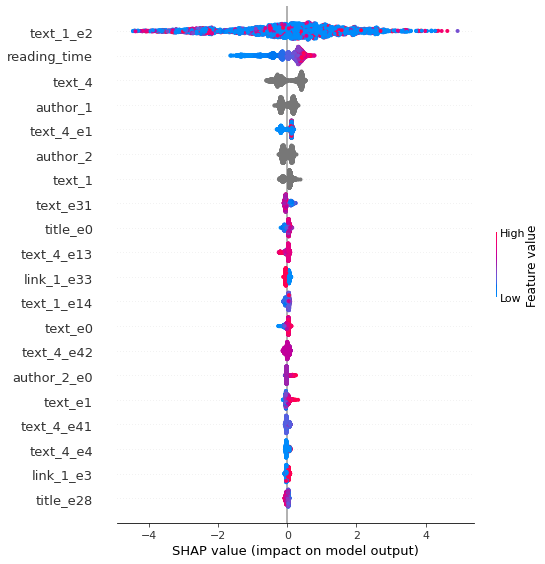

In [105]:
shap.summary_plot(shap_values, train_part_X)